<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Object Detection

### Using Deployment

Using the sliding window approach involves deploying an image classifier trained to classify 256X256 portions of an image as either "dog" or "cat" to an application that moves across an image one 256X256 section at a time. While this is not the perfect solution, it will:

1) Exemplify a powerful way to combine deep learning and traditional programming to create previously impossible applications  
2) Lead to a launch point to learning about neural network architecture

In the first section of this course, you learned to successfully *train* and *deploy* a neural network. You saw that while traditional programming was inadequate for classifying images, deep learning makes it not only possible, but straightforward.

By this point, you have taken an off-the-shelf neural network and an open source dataset (dogs vs. cats) and created a model that could correctly classify new animals that were both like and unlike your initial dataset. Pretty powerful!

In **this** task, you'll learn to solve problems *beyond image classification* with deep learning by:

- Combining deep learning with traditional computer vision
- Modifying the internals (the actual math) of neural networks
- Choosing the right network for the job

to solve a second deep learning challenge:

**Can we *detect* and *localize* objects within images?**

Let's start by instantiating our model in the same way we did in the last section. We bring in the model and dataset job directories to make use of the model architecture, trained weights, and preprocessing information such as the mean image. 

In [36]:
import time

import caffe   # caffe is our deep learning framework (Caffe has now been merged with Torch)
import matplotlib.pyplot as plt  # matplotlib.pyplot allows us to visualize results
import numpy as np   # image data is often stored as numpy arrays of RGB (or BGR) pixel values

# this "inline" setting allows for matplotlib visualizations within Jupyter notebooks
%matplotlib inline

MODEL_JOB_DIR = '/dli/data/digits/20180301-185638-e918'  ## Remember to set this to be the job directory for your model
DATASET_JOB_DIR = '/dli/data/digits/20180222-165843-ada0'  ## Remember to set this to be the job directory for your dataset

MODEL_FILE = MODEL_JOB_DIR + '/deploy.prototxt'                 # This file contains the description of the network architecture
PRETRAINED = MODEL_JOB_DIR + '/snapshot_iter_735.caffemodel'    # This file contains the *weights* that were "learned" during training
MEAN_IMAGE = DATASET_JOB_DIR + '/mean.jpg'                      # This file contains the mean image of the entire dataset. Used to preprocess the data.

# Tell Caffe to use the GPU so it can take advantage of parallel processing. 
# If you have a few hours, you're welcome to change gpu to cpu and see how much time it takes to deploy models in series. 
caffe.set_mode_gpu()

# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# load the mean image from the file
mean_image = caffe.io.load_image(MEAN_IMAGE)

print("Ready to predict.")

Ready to predict.


Next, we'll take an image directly from a front door security camera. Note, this image is larger than 256X256. We want to know *where* a dog is in this image.

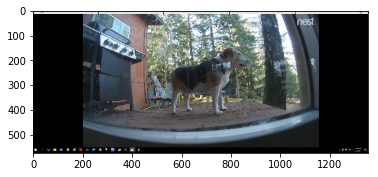

In [37]:
IMAGE_FILE = '/dli/tasks/task5/task/images/LouieReady.png'
input_image= caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

### Using our *learned* function: Forward Propagation

This is what we care about. Let's take a look at the function:   
<code>prediction = net.predict([grid_square])</code>.

Like any [function](https://www.khanacademy.org/computing/computer-programming/programming#functions), <code>net.predict</code> passes an input, <code>grid_square</code>, and returns an output, <code>prediction</code>. Unlike other functions, this function isn't following a list of steps, instead, it's performing layer after layer of matrix math to transform an image into a vector of probabilities.  

Run the cell below to see the prediction from the top left 256X256 <code>grid_square</code> of our random image.

In [38]:
X = 0
Y = 0

grid_square = input_image[X*256:(X+1)*256,Y*256:(Y+1)*256]

# subtract the mean image (because we subtracted it while we trained the network - more on this in next lab)
grid_square -= mean_image

# make prediction
prediction = net.predict([grid_square])

print prediction

[[ 0.89857852  0.10142148]]


This is the output of the last layer of the network we're using. The type of layer is "softmax," where the higher the value of each cell, the higher the likelihood of the image belonging to that class. For example, above, if the second cell of the vector is higher than the first (and the network has been trained), that section of the image likely contains a *dog*. Since in this case, the first cell is *much* higher, it is very clear the network does not detect a dog in the top left 256X256 grid square.

Optional: [Explore the math of softmax.](https://en.wikipedia.org/wiki/Softmax_function)

Next, let's implement some code around our function to iterate over the image and classify each grid_square to create a heatmap. Note that the key lesson of this section is that we could have built ANYTHING around this function, limited only by your creativity.

Depending on your programming (specifically Python) experience, you may get very different information out of the following cell. At its core, this block is cutting our input image into 256X256 squares, running each of them through our dog classifier, and creating a new image that will show yellow where there is a dog and purple where there is not, *as determined by our classifier.* 

Note! Don't expect high perfomance/accuracy...yet!

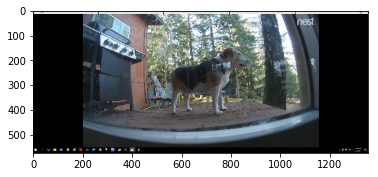

Total inference time: 0.813410997391 seconds


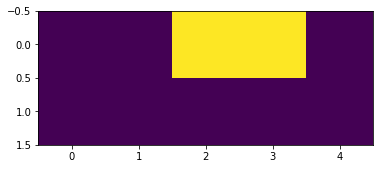

In [4]:
# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # subtract the mean image
        grid_square -= mean_image
        # make prediction
        prediction = net.predict([grid_square]) 
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections, interpolation=None)

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'

Again, this is the output of a randomly chosen wide area test image along with an array showing the predicted class for each non-overlapping 256x256 grid square when input in to the model.

Before we address what could be done better, take a minute to reflect on what we just did by responding to the following question:

**In your own words, how did we just use an image classifier to detect objects?**

The intent of this section was to show that any deep learning solution is still just a mapping from input to output. This realization brings us one step closer to being able to understand how more complex solutions get built. For example, voice assistants like Alexa, Google Assistant, and Siri have to convert raw sound data into text, text into understanding, and understanding into a desired task like playing your favorite song.

<a id='question1'></a>

The complexity can be as far reaching as anything that has or can been built with computer science. As a coding/problem solving challenge, what are some factors we didn't think about when building this solution and how could we account for them?

Potential Answer: [Click here](#answer1)

### 1.4 Challenging optional exercises:

<a id='question-optional-exercise'></a>

1. Keeping the grid square size as 256x256, modify the code to increase the overlap between grid squares and obtain a finer classification map.

2. Modify the code to batch together multiple grid squares to pass in to the network for prediction.

Answer: [Click here](#answer-optional-exercise)

As we have now seen, the advantage of this sliding window approach is that we can train a detector using only patch-based training data (which is more widely available) and that with our current skillset, we can start working to solve the problem.

We could keep tweaking our code and see if we can continue to solve our problems (inaccurate, slow) with brute force, OR, we could learn a bit more about deep learning. Let's go with the latter.

## Approach 2 - Rebuilding from an existing neural network

Remember, deep neural networks are inspired by the human brain. This section will show how to *change* a network to change its behavior and performance. At their core, these networks are made of math, and changing the math changes the brain. This section will not be a comprehensive dive into the details of *why* each type of network is ideal for each type of problem. That is an intuition that will be developed over time. Instead, this section will highlight the constraints to keep in mind as you experiment. We may introduce a few common layer types, but those are not the main takeaway as you leave this course.

Let's start with an exploration of our current network, AlexNet.

### 2.1 Our current network

The structure of these networks are described in some type of *framework,* in this case, Caffe. There are [many different frameworks](https://developer.nvidia.com/deep-learning-frameworks), each of which allow a practitioner to describe a network at a high level vs. having to physically program a GPU to do tensor math.

We need to go back to DIGITS.

## [Launch DIGITS here](/digits)

To look at AlexNet's Caffe description in DIGITS:

1) Select the model "Dogs vs. Cats".  
2) Select "Clone Job" (on the top right in blue) to copy all of the settings to a new network. Cloning networks is an important way to iterate as you experiment.  
3) At the bottom of the model settings, where you selected AlexNet, select "Customize."  

![](images/customize.png)

You'll see some *prototext.* That is the Caffe description of the AlexNet network. Feel free to explore a bit to see how it's structured. In other frameworks, you would see something similar, it would just have different syntax.

Next, at the top of the network, select "Visualize" to, you guessed it, visualize the AlexNet network.

![](images/visualize.png)

While what's in here might not mean much to you...yet, the first thing to note is that what's written in the prototext directly informs what's displayed in the visualization. Prove it to yourself. Change the *name* of the first layer, *train-data* to *your name* and select *visualize* again. 

There you go...full control!

Now put it back to *train-data* and we'll change something that matters, the math.

We're going to replace some layers of the AlexNet network to create new functionality AND make sure that the network still trains. 

### 2.2 Brain Surgery

Let's start by replacing one layer and making sure that everything is still hooked up correctly. 

In the prototext, find the layer with the name "fc6." You can see that there's a lot of information about *what* this layer does. We'll get there. For now, let's just replace it. Replace all of the prototext between the word "layer" and the closing [bracket](#bracket "}") before the next "layer" with the following:

```
layer {
  name: "conv6"
  type: "Convolution"
  bottom: "pool5"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    pad: 0
    kernel_size: 6
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
```

Let's *visualize* the network to compare our new network to the original AlexNet. For reference, this was the beginning of the original:

![](images/AlexNet%20beginning.PNG)

and this was the end:

![](images/AlexNetEnd.PNG)

Why might this indicate that we've broken something?

What do you think we could do to fix what we've broken?

### 2.3 Finishing the job

#### Rule 1: Data must be able to flow

We removed the fc6 layer, but it's clear that it's still present when we visualize our network. This is because *there are other layers that reference fc6:* 

- fc7
- drop6
- relu6

Take a look at the Caffe prototext to see where those layers are *told* to connect to fc6 and connect them instead to your new layer, <code>conv6</code>.

**Visualize again.** Your network should again show that data flows from and to the same inputs and outputs as the original AlexNet.

As the data flows from input to output, there are many "hidden layers," that perform some operation (math). The output of each layer needs to be defined as the input of the next. These create massively compound functions, which allow deep learning to model increasingly complex real world relationships between inputs and outputs. 

On one hand, we can use ANY math we want, as long as we keep everything connected so the data can flow from input to output. On the other:

#### Rule 2: The math matters

Let's take a second to compare the layer we removed with the layer we added. 

We removed a "fully connected" layer, which is a traditional matrix multiplication. While there is a lot to know about matrix multiplication, the one characteristic that we'll address is that matrix multiplication only works with specific matrix sizes. The implications of this for our problem is that we are limited to fixed size images as our input (in our case 256X256).

We added a "convolutional" layer, which is a "filter" function that moves over an input matrix. There is also a lot to know about convolutions, but the one characteristic that we'll take advantage of is that they **do not** only work with specific matrix sizes. The implications of this for our problem are that if we replace all of our fully connected layers with convolutional layers, we can accept any size image. 

**By converting AlexNet to a "Fully Convolutional Network," we'll be able to feed images of various sizes to our network without first splitting them into grid squares.**

Let's convert AlexNet into a Fully-Convolutional Network (somewhat confusingly referred to as an FCN). Replace `fc7` through `fc8` with equivalent convolutional layers using the following Caffe text. 

**Important: This replacement should END at the end of the 'fc8' definition.**

```
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu7"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "drop7"
  type: "Dropout"
  bottom: "conv7"
  top: "conv7"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 2
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
```

Is there anything else that you must change in your network to make sure that everything is still hooked up properly? If you're not sure, *visualize* your network again to help assess. If you still need a hint, hover [here](#rewiring "Remember to change the `bottom` blob of the `loss`, `accuracy` and `softmax` layers from 'fc8' to `conv8`.").

Once you feel confident that everything is hooked up properly, let's train a new model!

![](images/createmodel.PNG)

Give your model a name and select *create,* and while it trains, watch the video below to learn more about the convolutions you just added to your network.

<a href="https://youtu.be/BBYnIoGrf8Y?t=13"> <img src="images/Convolutions.png" alt="What are convolutions." style="width: 400px;"/> </a>


If you get no errors, great job! If you get one, read it. It will likely let you know where you've missed something. Commonly, the mistake lies [here](#rewiring "Remember to change the `bottom` blob of the `loss`, `accuracy` and `softmax` layers from 'fc8' to `conv8`."). If you just want the solution, click [here](#gu).

<a id='fcn'></a>

**Once you have a trained model, replace the ##FIXME## below with your new "Model Job Directory" like you did in the first section.

In [28]:
JOB_DIR = '/dli/data/digits/20190827-163751-3851'  ## Remember to set this to be the job directory for your model

Feel free to examine the code to see the difference between using this model and using AlexNet out of the box, but the main takeaway is that we feed the *entire* image through our trained model instead of grid squares.

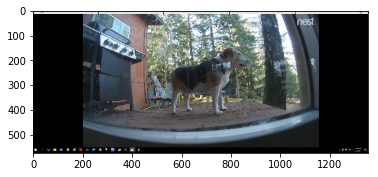

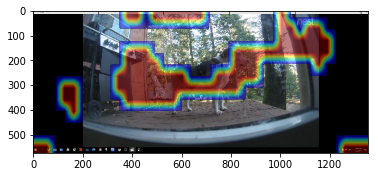

Total inference time: 0.125611066818 seconds


In [30]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import copy
from scipy.misc import imresize
import time

MODEL_FILE = JOB_DIR + '/deploy.prototxt'                 # Do not change
PRETRAINED = JOB_DIR + '/snapshot_iter_735.caffemodel'    # Do not change                 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Initialize the Caffe model using the model trained in DIGITS
# This time the model input size is reshaped based on the randomly selected input image
net = caffe.Net(MODEL_FILE,PRETRAINED,caffe.TEST)
net.blobs['data'].reshape(1, 3, input_image.shape[0], input_image.shape[1])
net.reshape()
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

# This is just a colormap for displaying the results
my_cmap = copy.copy(plt.cm.get_cmap('jet')) # get a copy of the jet color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

# Feed the whole input image into the model for classification
start = time.time()
out = net.forward(data=np.asarray([transformer.preprocess('data', input_image)]))
end = time.time()

# Create an overlay visualization of the classification result
im = transformer.deprocess('data', net.blobs['data'].data[0])
classifications = out['softmax'][0]
classifications = imresize(classifications.argmax(axis=0),input_image.shape,interp='bilinear').astype('float')
classifications[classifications==0] = np.nan
plt.imshow(im)
plt.imshow(classifications,alpha=.5,cmap=my_cmap)
plt.show()

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'

As you run the above code multiple times you will see that in many cases the Fully Convolutional Network is able to locate the dog with greater precision than the sliding window approach. Also, the total inference time for the FCN is about 0.8 seconds, whereas for the sliding window approach it took 2.6 seconds.  We get a better quality result in a fraction of the time!  This is a great benefit if we wish to deploy our detector in a real-time application, e.g. on board an aircraft, as we obtain a single model that can perform detection and classification in one efficient pass.

However, often it will miss parts of the dog or falsely detect pieces that are not a dog. Again, the false alarms caused by background clutter and the dog could be mitigated using strategies like appropriate data augmentation and other data work outside of the neural network.

Can we solve more of this problem within the network itself? 

The short answer is: yes.

The long answer is: by using an end-to-end object detection network *designed* to detect and localize dogs. We'll use DetectNet trained using the [COCO](http://cocodataset.org/#home) dataset. Before proceeding, run the following cell to free memory. 

In [31]:
try:
    del transformer
    del net
    del detections
except Exception as e:
    print e

## Approach 3: DetectNet

We started this lab with AlexNet, an elegant solution to the very specific problem of *image classification*. We built some python around it and then performed minor brain surgery to accomplish a task that we wouldn't have been able to prior to our work in deep learning, *object detection.*

However, is there an elegant solution to *object detection?* Could we build a model that maps directly from the input you have: photos of various sizes, to the output you want: localization and detection information? 

The fact that there is will help us to broaden our definition of Deep Learning and provide some insight into what *other* problems you can solve with it.

This course began with a discussion of the three ingredients that make deep learning possible.

1) Deep Neural Networks  
2) The GPU  
3) Big Data  

As we go beyond image classification, these ingredients remain the same, but the types of networks, data, and use of GPU change. We'll start with data since that's how our workflow in DIGITS is structured.

### Difference in Data

To build an end-to-end supervised deep learning workflow, we'll need labeled data. Until this point, we've defined "labeled" as an indicator of which category each image belonged to. However, the real task of labeling data is **curating input output mappings." 

In this case, we want our inputs to be an image of ANY size and our outputs to indicate the location of objects within the image. First, an input image:

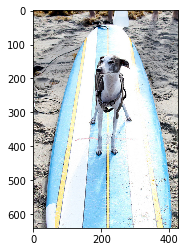

In [32]:
input_image = caffe.io.load_image('/dli/data/train/images/488156.jpg') #!ls this directory to see what other images and labels you could test
plt.imshow(input_image)
plt.show()

Next, its corresponding label:

In [33]:
!cat '/dli/data/train/labels/488156.txt' #"cat" has nothing to do with the animals, this displays the text

dog 0 0 0 161.29 129.03 291.61 428.39 0 0 0 0 0 0 0
surfboard 0 0 0 31.25 36.44 410.41 640.0 0 0 0 0 0 0 0


Note:

1) The input and its corresponding output are correlated based on the file number.  
2) The vector you're seeing consists of the (x,y) coordinates of the top left and bottom corner of the dog in the input image.  
3) If we had enough data with surfboards, we could train a surfboard detector instead of a dog detector! We'll set our dataset to only look for dogs.  

Let's load this dataset to DIGITS.

From [DIGITS](/digits) home screen, select "Datasets", and add a new **"Object Detection" dataset.** Note that the parameters will look different than with classification. 

When the "New Object Detection Dataset" panel opens, use the preprocessing options from the image below (**Watch for leading/training spaces**):

Training image folder: /dli/data/train/images  
Training label folder: /dli/data/train/labels  
Validation image folder: /dli/data/val/images  
Validation label folder: /dli/data/val/labels/dog  
Pad image (Width x Height): 640 x 640  
Custom classes: dontcare, dog  
Group Name: MS-COCO  
Dataset Name: coco-dog  

![OD data ingest](images/OD_ingest.png)

Note: You don't have to wait for the dataset to finish loading before beginning to configure the model training job.

### Difference in Networks

That there are different types of artificial "brains" that are designed to *learn* different types of things. Learning which architectures have been used to solve problems similar to yours is one of the core skills of successful Deep Learning. In Approach 2, you saw how changing a few constraints could change the behavior of a network. In Approach 3, we'll demonstrate the benefits of research, expertise, and iteration with the caveat that you can use these networks and models without being their designer. The challenge faced by the designers of the network we'll use was **what is the most efficient and accurate way to map the input output pairings from our data?**

Let's load and visualize the network to get an idea of how diverse these networks can get.

Return to DIGITS' home screen by selecting DIGITS on the top-left of the screen. Create a new Object Detection **model** by selecting Images -> Object Detection. 

Select the dataset you just loaded, "coco-dog".

For reasons we'll state shortly, change the number of epochs to 1 and the learning rate to 1e-100. Where you would usually select a network, select "Custom Network", which should open a blank window. 

We found this network description with a search for "DetectNet deploy.prototxt". Your job is to copy and paste the text from this link: [deploy.prototxt](../../../../edit/tasks/task5/task/deploy.prototxt) into the exposed field. As you do this, note that it's this easy to share network architecture.

Next, visualize the network by selecting "visualize". Note the difference in size and complexity of this network compared to AlexNet.  DetectNet is actually an Fully Convolutional Network (FCN), as we built above, but configured to produce precisely this data representation as its output.  The bulk of the layers in DetectNet are identical to the well-known GoogLeNet network.


Don't train yet!

### Difference in Compute

With the increase in the depth of the network and the complexity of the task, this will take *more training* than the networks we have been working with so far. The model we will use to demonstrate the power of this workflow took about 16 hours to train on a NVIDIA Tesla K80 (less time on a Volta, a lifetime on a CPU). 

So, instead of training from scratch, we will start with a pretrained model and train for one epoch with a very slow learning rate (which you already set in the steps above.)

To load the weights that have already been learned, load the weights to the field <code>Pretrained Model(s)</code> with the file:<pre>/dli/data/digits/snapshot_iter_38600.caffemodel</pre>

[](images/loadsnapshot.PNG)

Name your model and then "train" it to see the difference between image classification and object detection.

As your model trains, you will see a different measure of performance than was reported for Image Classification models. The mean Average Precision (mAP) is a combined measure of how well the network can detect the dogs and how accurate its bounding box (localization) estimates were for the validation dataset.

You will see that after 100 training epochs this model had not only converged to low training and validation loss values, but also a high mAP score.  Let's test this trained model against our test image to see if it can find a dog.

**Set the visualization method to "Bounding boxes"** and paste the following image path in:  `/dli/data/BeagleImages/LouieTest1.jpg`.  Click "Test One".  You should see DetectNet successfully detects Louie and draws a bounding box.

To access a list of other images to try, run the following cell and note that the '!' in Jupyter notebooks makes these cells act like the command line.

In [34]:
!ls /dli/data/BeagleImages

Louie  LouieTest1.jpg  Not Louie  louietest2.JPG


Feel free to test other images from the `/dli/data/BeagleImages` folder.  You will see that DetectNet is able to accurately detect most dogs with a tightly drawn bounding box and has a very low false alarm rate. It is also worth noting that this model can detect multiple classes of objects!

There are a few key takeaways here:

1. The right network and data for the job at hand are vastly superior to hacking your own solution.
2. The right network (and sometimes even pretrained model) might be available in DIGITS or on the [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) of your framework.

So one problem solving framework you can use is:

- determine if someone else has already solved your problem, use their model
- if they have not, determine if someone else has already solved a problem *like* yours, use their network and your data
- if they have not, determine if you can identify the shortcomings of someone else's solution in solving your problem and work to design a new network
- if you can not, use an existing solution and other problem solving techniques (eg. python) to solve your problem
- either way, continue to experiment and take labs to increase your skill set!

Congratulations! You have reached the end of our course. In the next section, you'll get to test your knowledge. 

You've learned:

- How to train multiple types of neural networks using DIGITS
- What types of changes you can make to *how* you train networks to improve performance
- How to combine deep learning with traditional programming to solve new problems
- How to modify the internal layers of a network to change functionality and limitations
- to see who else has worked on problems like yours and what parts of their solution you can use

The assessment in the next section checks whether you can *train and deploy a neural network to classify images."* Before you take it, we've provided some resources about how to set up your own environment to match what you've been working in throughout tihs course, a fun project to try after you complete the course, and a survey where you can share your feedback so we can continue to improve the course materials, instructor training, and overall learning experience.<a href="https://courses.nvidia.com/courses/course-v1:DLI+C-FX-01+V2/courseware/07650a877e434f17943e884366736406/b5914d0e8caf4fbc85858db2041d074a/1?activate_block_id=block-v1%3ADLI%2BC-FX-01%2BV2%2Btype%40vertical%2Bblock%409d60e3770c694d76a0992d4649afc6bc"> Start with the survey here. (Be sure to click "Done" to submit your answers.)
<img src="images/DLI Header.png" alt="Header" style="width: 300px;"/></a></font>

## Answers to questions:

<a id='answer1'></a>
### Answer 1

The fact that we used a sliding window with non-overlapping grid squares means that it is very likely that some of our grid squares will only partially contain a dog and this can lead to misclassifications. However, as we increase the overlap in the grid squares we will rapidly increase the computation time for this sliding window approach. We can make up for this increase in computation by *batching* inputs, a strategy that takes advantage of the GPU's intrinsic strength of parallel processing.

[Click here](#question1) to return to the lab.

<a id='answer-optional-exercise'></a>

### Answer to optional exercise


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import time

MODEL_JOB_DIR = '##FIXME##'  ## Remember to set this to be the job number for your model
DATASET_JOB_DIR = '##FIXME##'  ## Remember to set this to be the job number for your dataset

MODEL_FILE = MODEL_JOB_DIR + '/deploy.prototxt'                 # Do not change
PRETRAINED = MODEL_JOB_DIR + '/snapshot_iter_735.caffemodel'    # Do not change
MEAN_IMAGE = DATASET_JOB_DIR + '/mean.jpg'                      # Do not change

# load the mean image
mean_image = caffe.io.load_image(MEAN_IMAGE)

# Choose a random image to test against
#RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = '/dli/data/LouieReady.png' 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Subtract the mean image
for i in range(0,rows):
    for j in range(0,cols):
        input_image[i*256:(i+1)*256,j*256:(j+1)*256] -= mean_image
        
# Initialize an empty array for the detections
detections = np.zeros((rows,cols))
        
# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (sliding window without overlap): ' + str(end-start) + ' seconds'

# define the amount of overlap between grid cells
OVERLAP = 0.25
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print "Image has %d*%d blocks of 256 pixels" % (rows, cols)
print "With overlap=%f grid_size=%d*%d" % (OVERLAP, grid_rows, grid_cols)

# Initialize an empty array for the detections
detections = np.zeros((grid_rows,grid_cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,grid_rows):
    for j in range(0,grid_cols):
        start_col = int(j*256*(1-OVERLAP))
        start_row = int(i*256*(1-OVERLAP))
        grid_square = input_image[start_row:start_row+256, start_col:start_col+256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print ('Total inference time (sliding window with %f%% overlap: ' % (OVERLAP*100)) + str(end-start) + ' seconds'

# now with batched inference (one column at a time)
# we are not using a caffe.Classifier here so we need to do the pre-processing
# manually. The model was trained on random crops (256*256->227*227) so we
# need to do the cropping below. Similarly, we need to convert images
# from Numpy's Height*Width*Channel (HWC) format to Channel*Height*Width (CHW) 
# Lastly, we need to swap channels from RGB to BGR
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
start = time.time()
net.blobs['data'].reshape(*[grid_cols, 3, 227, 227])

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # add to batch
        grid_square = grid_square[14:241,14:241] # 227*227 center crop        
        image = np.copy(grid_square.transpose(2,0,1)) # transpose from HWC to CHW
        image = image * 255 # rescale
        image = image[(2,1,0), :, :] # swap channels
        net.blobs['data'].data[j] = image
    # make prediction
    output = net.forward()[net.outputs[-1]]
    for j in range(0,cols):
        detections[i,j] = output[j].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (batched inference): ' + str(end-start) + ' seconds'

When you're done, go [back to the lab.](#question-optional-exercise)

<a id='gu'></a>
# Fully Convolutional Network Solution

You can replace **all** of the text in AlexNet with the following to successfully convert it to a fully convolutional network. After copying, return to the lab by clicking [here](#fcn).

```# AlexNet
name: "AlexNet"
layer {
  name: "train-data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: true
    crop_size: 227
  }
  data_param {
    batch_size: 128
  }
  include { stage: "train" }
}
layer {
  name: "val-data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    crop_size: 227
  }
  data_param {
    batch_size: 32
  }
  include { stage: "val" }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "conv1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "norm1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 2
    kernel_size: 5
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "conv2"
  top: "conv2"
}
layer {
  name: "norm2"
  type: "LRN"
  bottom: "conv2"
  top: "norm2"
  lrn_param {
    local_size: 5
    alpha: 0.0001
    beta: 0.75
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "norm2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv3"
  type: "Convolution"
  bottom: "pool2"
  top: "conv3"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 384
    pad: 1
    kernel_size: 3
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu3"
  type: "ReLU"
  bottom: "conv3"
  top: "conv3"
}
layer {
  name: "conv4"
  type: "Convolution"
  bottom: "conv3"
  top: "conv4"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 384
    pad: 1
    kernel_size: 3
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu4"
  type: "ReLU"
  bottom: "conv4"
  top: "conv4"
}
layer {
  name: "conv5"
  type: "Convolution"
  bottom: "conv4"
  top: "conv5"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 256
    pad: 1
    kernel_size: 3
    group: 2
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu5"
  type: "ReLU"
  bottom: "conv5"
  top: "conv5"
}
layer {
  name: "pool5"
  type: "Pooling"
  bottom: "conv5"
  top: "pool5"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv6"
  type: "Convolution"
  bottom: "pool5"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    pad: 0
    kernel_size: 6
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu6"
  type: "ReLU"
  bottom: "conv6"
  top: "conv6"
}
layer {
  name: "drop6"
  type: "Dropout"
  bottom: "conv6"
  top: "conv6"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu7"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "drop7"
  type: "Dropout"
  bottom: "conv7"
  top: "conv7"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 2
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "conv8"
  bottom: "label"
  top: "accuracy"
  include { stage: "val" }
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "conv8"
  bottom: "label"
  top: "loss"
  exclude { stage: "deploy" }
}
layer {
  name: "softmax"
  type: "Softmax"
  bottom: "conv8"
  top: "softmax"
  include { stage: "deploy" }
}
```

After copying, return to the lab by clicking [here](#fcn).